# Imports e Downloads

In [1]:
import random
import json
import pickle
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
import spacy

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam

from pprint import pprint

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
nlp = spacy.load("pt_core_news_lg")

In [5]:
intents_file = r'/content/all_intents_v2_1_SEPEX.json'
intents = json.loads(open(intents_file).read())

In [6]:
# Exibir
pprint(intents)

{'intents': [{'patterns': ['Qual é a versão mais recente do programa?',
                           'Qual é a edição mais atual do software?',
                           'Pode me informar sobre a versão mais nova do '
                           'aplicativo?',
                           'Qual é a versão mais recente disponível do '
                           'programa?',
                           'Qual é a versão mais atual do programa?',
                           'Qual é a versão do programa em uso no momento?',
                           'Pode me atualizar sobre a versão atual do '
                           'programa, por favor?',
                           'Pode me fornecer informações sobre a versão mais '
                           'recente do programa, por gentileza?',
                           'Diga-me qual é a versão mais recente do programa.',
                           'Estou interessado na versão atual do programa.',
                           'Estou interessado em saber a

# Funções

## Pré-processamento

In [7]:
# Caracteres ignorados no processamento de dados
ignore_letters  = ['?', '!', '.', ',', '4test4']

In [8]:
# Transforma uma frase em uma lista de palavras
def tokenizar(intents: dict):

  words = []
  classes = []
  documents = []
  print('\033[1;34mIniciando Tokenização... \033[0m')
  try:
    vocabulario = []
    categorias = []
    tuplas = []
    for intent in intents['intents']:
      for pattern in intent['patterns']:
        tokenizado = nltk.word_tokenize(pattern.lower(), language='portuguese')
        vocabulario.extend(tokenizado)
        tuplas.append(tuple([intent['tag'], tokenizado]))

      categorias.append(intent['tag'])
    print('\033[1;32m Vocabulário gerado com sucesso! (1/3)')
    print('\033[1;32m Categorias documentadas com sucesso! (2/3)')
    print('\033[1;32m Tuplas geradas com sucesso! (3/3)')

  except Exception as e:
    print(f'\033[1;31mA Tokenização falhou! Motivo: {repr(e)} \033[0m')
    return False

  print('\033[1;34mTokenização concluída! \033[0m')
  return vocabulario, categorias, tuplas

In [9]:
# Extrai o lema das palavras de uma frase
def lematizar(texto: list, tipo=0):
  separador = None
  match tipo:
     case 0:
      separador = ''
     case 1:
      separador = ' '
  try:
    if type(separador) != str:
      raise ValueError(f'Tipo de separador inválido: {tipo}. Utilize 0 para nenhum ou 1 para espaço simples.')
      print(test)
  except Exception as e:
    print(f'\033[1;31mFalha na Lematização! Motivo: {repr(e)} \033[0m')
    return False
  if len(texto) == 1:
    texto.append('4test4')
  texto = separador.join(texto)
  docc = nlp(texto)
  lematizado = []
  for tkn in docc:
    if tkn.text not in ignore_letters:
      lematizado.append(tkn.lemma_)
  return lematizado

In [10]:
# Codifica uma frase em formato binário
def bag_of_words(vocabulario: list, docs: list) -> list:
  success = True
  d_treino = []
  output_vazio = [0] * len(categorias)

  print('\033[1;34mIniciando Bag of Words... \033[0m')
  try:
    for i, documento in enumerate(docs):
        compat = True
        bag = []
        patt_palavras = documento[0]
        compat = any(item in palavras for item in patt_palavras)
        if not compat:
          patt_palavras = ' '.join(patt_palavras).lower().split()
          compat = all(item in palavras for item in patt_palavras)
          if not compat:
            print(f'\033[1;31m Nem todas as palavras da seguinte pattern (pos {i})estão no vocabulário: {patt_palavras}\033[0m')
            raise RuntimeError(f"O vocabulário não é compatível com os documentos informados! "
                                "Verifique se a lematização ocorreu adequadamente.")
        for palavra in palavras:
          bag.append(1) if palavra in patt_palavras else bag.append(0)

        res_output = list(output_vazio)
        res_output[categorias.index(documento[1])] = 1
        d_treino.append([bag, res_output])
        print(f'\033[1;32m {i + 1}/{len(docs)} Patterns processadas. {len(docs) - i - 1} restante(s).')
  except RuntimeError as e:
    success = False
    print(f'\033[1;31mA Bag of Words não ocorreu apropriadamente! Motivo: {repr(e)} \033[0m')

  if success:
    print('\033[1;34mBag of Words concluída! \033[0m')
  return d_treino

In [11]:
# Separa os dados de previsão e a variável alvo
def feature_extraction(dados: list) -> tuple([list, list]):
  print('\033[1;34mIniciando Feature Extraction... \033[0m')
  try:
    random.shuffle(dados)
    print(f'\033[1;32m Dados embaralhados! (1/4)')

    dados = np.array(dados, dtype='object')
    print(f'\033[1;32m Dados convertidos! (2/4)')

    x_treino = list(dados[:, 0])
    print(f'\033[1;32m Variáveis preditoras separadas! (3/4)')
    y_treino = list(dados[:, 1])
    print(f'\033[1;32m Variáveis objetivo separadas! (4/4)')
  except Exception as e:
    print(f'\033[1;31mA Feature Extraction falhou! Motivo: {repr(e)} \033[0m')
    return False
  print('\033[1;34mFeature Extraction concluída! \033[0m')
  return x_treino, y_treino

### Carregar palavras e classes

In [12]:
#palavras = pickle.loads(open('', 'rb').read())
#categorias = pickle.loads(open('', 'rb').read())

### Tokenização e Lematização

Gerar *on-demand*

In [13]:
palavras_0, categorias, documentos = tokenizar(intents)

Iniciando Tokenização... 
 Vocabulário gerado com sucesso! (1/3)
 Categorias documentadas com sucesso! (2/3)
 Tuplas geradas com sucesso! (3/3)
Tokenização concluída! 


In [14]:
palavras = lematizar(palavras_0, 1)

In [15]:
def force_word(word):
  try:
   assert word in palavras, f'A palavra "{word}" não está no vocabulário!'
  except AssertionError as e:
    print(repr(e))
    palavras.append(word)
    print('Mas foi adicionada com sucesso!')

force_words = ['obrigar', 'nichola', 'jônata']
for word in force_words:
  force_word(word)

AssertionError('A palavra "obrigar" não está no vocabulário!')
Mas foi adicionada com sucesso!


In [16]:
palavras = sorted(set(palavras))
categorias = sorted(set(categorias))

In [17]:
vocab_file = r'vocabulario_avir_2_1_SEPEX.pkl'
categ_file = r'categorias_avir_2_1_SEPEX.pkl'

pickle.dump(palavras, open(vocab_file, 'wb'))
pickle.dump(categorias, open(categ_file, 'wb'))

## Preparar bag of words

In [18]:
l_docs = []
for documento in documentos:
      words_patterns = documento[1]
      pattern_lemmas = lematizar(words_patterns, 1)
      l_docs.append([pattern_lemmas, documento[0]])

In [19]:
bow = bag_of_words(palavras, l_docs)

Iniciando Bag of Words... 
 1/433 Patterns processadas. 432 restante(s).
 2/433 Patterns processadas. 431 restante(s).
 3/433 Patterns processadas. 430 restante(s).
 4/433 Patterns processadas. 429 restante(s).
 5/433 Patterns processadas. 428 restante(s).
 6/433 Patterns processadas. 427 restante(s).
 7/433 Patterns processadas. 426 restante(s).
 8/433 Patterns processadas. 425 restante(s).
 9/433 Patterns processadas. 424 restante(s).
 10/433 Patterns processadas. 423 restante(s).
 11/433 Patterns processadas. 422 restante(s).
 12/433 Patterns processadas. 421 restante(s).
 13/433 Patterns processadas. 420 restante(s).
 14/433 Patterns processadas. 419 restante(s).
 15/433 Patterns processadas. 418 restante(s).
 16/433 Patterns processadas. 417 restante(s).
 17/433 Patterns processadas. 416 restante(s).
 18/433 Patterns processadas. 415 restante(s).
 19/433 Patterns processadas. 414 restante(s).
 20/433 Patterns processadas. 413 restante(s).
 21/433 Patterns processadas. 412 restante

## Pós-processamento

In [20]:
# Tokeniza e lematiza a mensagem do usuário
def limpar_frase(frase):
  frase = frase.lower()
  lista_palavras = nltk.tokenize.word_tokenize(frase, language='portuguese')
  lista_lemas = lematizar(lista_palavras, 1)
  return lista_lemas

# Aplica a bag of words na mensagem do usuário
def codificar_frase(frase, palavras):
  lista_palavras = limpar_frase(frase)
  bag = [0] * len(palavras)
  for p in lista_palavras:
    for i, palavra in enumerate(palavras):
      if palavra == p:
        bag[i] = 1
  result = np.array(bag, dtype='object')
  return result

# Prevê a tag da mensagem recebida
def prever_categoria(frase, palavras, categorias, modelo, LE):
  bow = codificar_frase(frase, palavras)
  bow = np.asarray(bow).astype('float32')
  res = modelo.predict(np.array([bow]), verbose=0)[0]
  LIMIAR_DE_ERRO = LE
  resultados = [[i, r] for i, r in enumerate(res) if r > LIMIAR_DE_ERRO]
  resultados.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in resultados:
    return_list.append({"intent": categorias[r[0]], "probabilidade": str(r[1])})
  return return_list

# Determina a resposta mais adequada para o usuário
def escolher_resposta(intents_list, intents_json):
  if intents_list == []:
    return "Desculpe, não entendi."
  tag = intents_list[0]['intent']
  list_of_intents = intents_json['intents']
  for i in list_of_intents:
    if i['tag'] == tag:
      result = random.choice(i['responses'])
      break
  return result

# Estabelece um ambiente de testes no notebook
def interface_teste(modelo, vocabulario, classes, debug=False, LE=0.75):
  while True:
    mensagem = input('')
    if mensagem == '!exit':
      break
    ints = prever_categoria(mensagem, vocabulario, classes, modelo, LE)
    res = escolher_resposta(ints, intents)
    if debug:
      for intent in ints:
        prob = float(intent['probabilidade']) * 100
        print(f'\033[1;36mCategoria: {intent["intent"]} ({"%.2f" % prob}% de certeza)\033[0m')
    print(f'\033[1;32m      {res}\033[0m')

# Exibe a performance do modelo ao longo das epochs
def plotar_performance(h, version: str):
  figure, ax = plt.subplots(1, 2, figsize=(12, 6))

  ax[0].plot(h.history['loss'], 'o-', color='b')
  ax[0].set_title(f'Custo: Entropia Cruzada Categórica (CC-E)')
  ax[0].set_ylabel('CC-E')
  ax[0].set_xlabel('Epoch')
  ax[0].grid(linestyle='-.')

  ax[1].plot(h.history['accuracy'], 'o-', color='g')
  ax[1].set_title(f'Exatidão')
  ax[1].set_ylabel('Taxa de Acerto')
  ax[1].set_xlabel('Epoch')
  ax[1].grid(linestyle='-.')

  plt.suptitle(f'Métricas de performance do modelo AVIR v{version}')

  plt.show()

# Treinamento do Modelo de Recuperação

In [21]:
# Separa variáveis preditoras e alvo
X_train, y_train = feature_extraction(bow)

Iniciando Feature Extraction... 
 Dados embaralhados! (1/4)
 Dados convertidos! (2/4)
 Variáveis preditoras separadas! (3/4)
 Variáveis objetivo separadas! (4/4)
Feature Extraction concluída! 


In [22]:
# Inicializa um modelo
model = Sequential()

# Arquitetura da Rede Neural
model.add(Dense(units=320, input_shape=(len(X_train[0]),), activation='tanh'))
model.add(Dense(units=144, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=72, activation ='sigmoid'))
model.add(Dense(units=len(y_train[0]), activation='softmax'))

# Compila o modelo
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0003), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Treina o modelo
history = model.fit(np.array(X_train), np.array(y_train), epochs=20, batch_size=1, verbose=1)

Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0337 - loss: 3.5831
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1934 - loss: 3.0100
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3632 - loss: 2.5630
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4983 - loss: 2.1366
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6514 - loss: 1.7625
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7849 - loss: 1.4820
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7947 - loss: 1.2573
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9018 - loss: 1.0067
Epoch 9/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8797 - loss: 0.8612
Epoch 10/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9297 - loss: 0.7065
Epoch 11/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9550 - loss: 0.5591
Epoch 12/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

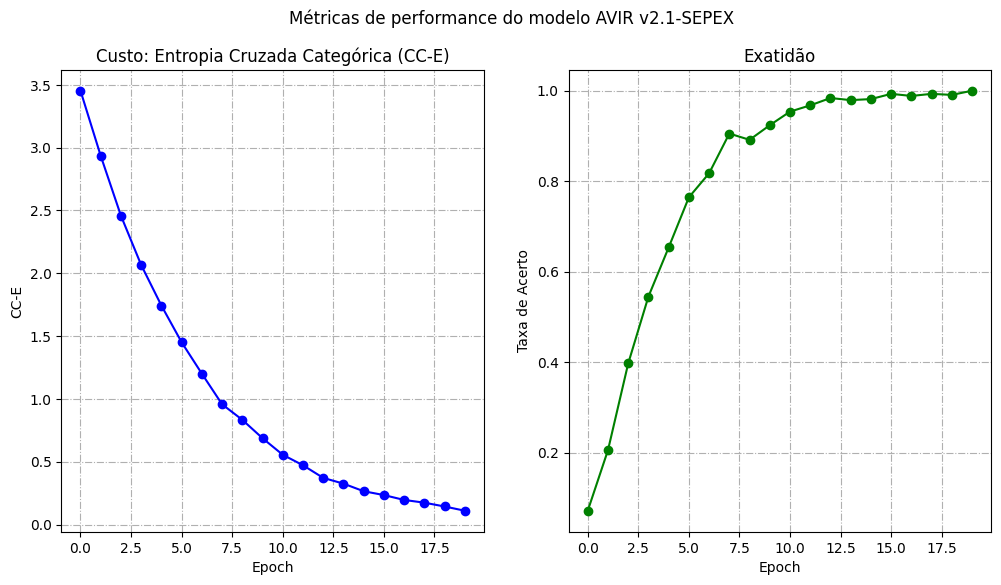

In [24]:
# Plota a performance do modelo
plotar_performance(history, '2.1-SEPEX')

# Salvamento

In [25]:
model_file = r'avir_v2_1_SEPEX.h5'

In [26]:
# Salva o modelo
model.save(model_file)

In [27]:
# Carrega um modelo
model = keras.models.load_model(model_file)

# Área de Testes Componente de Recuperação


In [28]:
# Utilizar debug=True para verificar as escolhas de categoria
# Responder !exit para encerrar a conversa
interface_teste(model, palavras, categorias, debug=True, LE=0.75)

Ola
      Desculpe, não entendi.
Olá
Categoria: Saudações (98.58% de certeza)
      Como posso facilitar as coisas para você?
Dannylo Mauricio
Categoria: Desenvolvedores (98.73% de certeza)
      Esta pessoa participou do projeto AVIR!!
Sepex
Categoria: SEPEx (87.68% de certeza)
      A Semana de Ensino, Pesquisa e Extensão busca a aproximação dos alunos a realidade do mercado de trabalho por meio de palestras, minicursos, mesas redondas e apresentação de trabalhos científicos.


KeyboardInterrupt: Interrupted by user


# Componente Generativo + Componente de Recuperação


In [ ]:
!pip install groq numpy nltk python-telegram-bot==13.7 spacy tensorflow

### Imports

In [ ]:
import random
import json
import pickle
import numpy as np
import nltk
import spacy
from telegram import Update
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext
from keras.models import load_model
from pprint import pprint
from groq import Groq
from typing import Dict, List
import logging
import os

from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type

### Config

In [ ]:
# TOKENS
telegram_tkn = "" # Telegram Token
groq_tkn = "" # Groq Token

In [ ]:
model_file = r'avir_v2_1_SEPEX.h5'
vocab_file = r'vocabulario_avir_2_1_SEPEX.pkl'
categ_file = r'categorias_avir_2_1_SEPEX.pkl'
intents_file = r'all_intents_v2_1_SEPEX.json'

In [ ]:
# Inicialização dos Recursos NLTK
nltk.download('punkt_tab')

# Configuração de Logging
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)

# IDs de Chat Permitidos
ALLOWED_CHAT_IDS = [-4502877507]  # Substitua pelos IDs dos seus grupos

# Carregamento dos Componentes AVIR
try:
    avir_model_path = model_file
    vocab_path = vocab_file
    categories_path = categ_file

    avir_model = load_model(avir_model_path)
    with open(vocab_path, 'rb') as f:
        vocabulario = pickle.load(f)
    with open(categories_path, 'rb') as f:
        categorias = pickle.load(f)

    nlp = spacy.load("pt_core_news_lg")
    ignore_letters = ['?', '!', '.', ',', '4test4']

    logger.info("Componentes AVIR carregados com sucesso.")
except Exception as e:
    logger.error(f"Falha ao carregar componentes AVIR: {e}")
    exit(1)

# Carregamento do JSON de Intents
intents_path = './all_intents_v2_1_SEPEX.json'
try:
    with open(intents_path, 'r', encoding='utf-8') as f:
        intents = json.load(f)
    logger.info("JSON de intents carregado com sucesso.")
except Exception as e:
    logger.error(f"Falha ao carregar JSON de intents: {e}")
    exit(1)

# Inicialização do Cliente Groq
os.environ["GROQ_API_KEY"] = groq_tkn
client = Groq()
DEFAULT_MODEL = "llama-3.2-3b-preview"

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Funções

In [ ]:
# Funções para Formatação de Mensagens para o Groq
def assistant(content: str) -> Dict[str, str]:
    return {"role": "assistant", "content": content}

def user_message(content: str) -> Dict[str, str]:
    return {"role": "user", "content": content}

@retry(
    wait=wait_exponential(multiplier=1, min=4, max=10),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(Exception)
)
def chat_completion(
    messages: List[Dict],
    model: str = DEFAULT_MODEL,
    temperature: float = 0.6,
    top_p: float = 0.9,
) -> str:
    response = client.chat.completions.create(
        messages=messages,
        model=model,
        temperature=temperature,
        top_p=top_p,
    )
    return response.choices[0].message.content

def complete_and_print(prompt: str, model: str = DEFAULT_MODEL) -> str:
    try:
        response = chat_completion([user_message(prompt)], model)
        return response
    except Exception as e:
        logger.error(f"Erro após tentativas: {e}")
        return "Desculpe, estou enfrentando dificuldades para responder no momento. Por favor, tente novamente mais tarde. 😞"

def prompt_with_rag(retrieved_info: str, question: str) -> str:
    prompt = ( # Use um prompt compatível com o seu objetivo final
        f"Você é a assistente virtual do Ramo Estudantil CEFET-RJ (AVIR), em exposição na SEPEX "
        f"(Semana de Pesquisa e Extensão). Use emojis na resposta. Dado o contexto/exemplo de resposta a seguir: "
        f"'{retrieved_info}', responda de forma elaborada: '{question}'"
    )
    return complete_and_print(prompt)

# Funções de NLP do AVIR
def escolher_resposta(intents_list: list, intents_json: dict) -> str:
    if not intents_list:
        return "(Contexto de exemplo não encontrado)"
    tag = intents_list[0]['intent']
    for intent in intents_json['intents']:
        if intent['tag'] == tag:
            return random.choice(intent['responses'])
    return "(Contexto de exemplo não encontrado)"



# Gerenciamento de Contexto por Usuário
user_context = {}  # Dicionário para armazenar contexto por chat_id

# Funções do Bot do Telegram
def start(update, context: CallbackContext) -> None:
    chat_id = update.effective_chat.id
    update.message.reply_text('Olá! Eu sou o AVIR, a assistente virtual da CEFET-RJ. Como posso ajudar você hoje? 😊')
    user_context[chat_id] = []  # Inicializa o contexto para o chat_id

def handle_message(update, context: CallbackContext) -> None:
    chat_id = update.effective_chat.id
    if chat_id not in ALLOWED_CHAT_IDS and update.effective_chat.type != 'private':
        logger.info(f"Mensagem de chat não autorizado: {chat_id}")
        return

    if update.message.text:
        message_text = update.message.text
        logger.info(f"Recebida mensagem: {message_text} de chat_id: {chat_id}")

        try:
            # Processamento com AVIR
            intents_list = prever_categoria(message_text, vocabulario, categorias, avir_model, 0.75)
            response = escolher_resposta(intents_list, intents)

            # Gerenciamento de Contexto
            context_history = user_context.get(chat_id, [])
            # Adiciona a nova pergunta ao histórico
            context_history.append({"role": "user", "content": message_text})

            # Geração de Resposta com Contexto usando Groq
            retrieved_info = " ".join([msg['content'] for msg in context_history])
            generated_response = prompt_with_rag(response, message_text)

            # Atualiza o contexto com a resposta gerada
            context_history.append({"role": "assistant", "content": generated_response})
            user_context[chat_id] = context_history  # Atualiza o histórico no dicionário

            # Envia a resposta ao usuário
            update.message.reply_text(generated_response)
            logger.info(f"Respondido com: {generated_response}")

        except Exception as e:
            logger.error(f"Erro ao processar mensagem: {e}")
            # Resposta de fallback caso ocorra erro
            fallback_response = "Desculpe, estou enfrentando dificuldades para responder no momento. Por favor, tente novamente mais tarde. 😞"
            update.message.reply_text(fallback_response)
    else:
        update.message.reply_text("Desculpe, só consigo processar mensagens de texto no momento.")

# Interface (Telegram)

In [ ]:
def main():

    # Inicializa o Updater e Dispatcher
    updater = Updater(telegram_tkn, use_context=True)
    dp = updater.dispatcher

    # Registra os Handlers
    dp.add_handler(CommandHandler("start", start))
    dp.add_handler(MessageHandler(Filters.text & (~Filters.command), handle_message))

    # Inicia o Bot
    updater.start_polling()
    logger.info("Bot iniciado com sucesso.")

    # Executa o bot até que seja interrompido
    updater.idle()

if __name__ == '__main__':
    main()
